In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import joblib

# Cargar los datos
df = pd.read_csv(r'c:\Users\Administrator\OneDrive\Documentos\GitHub\G5_D.Scientist\dataset_balanceado_encoded.csv')

# Separar características y variable objetivo
X = df.drop('stroke', axis=1)
y = df['stroke']

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Definir el espacio de parámetros para XGBoost
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

# Realizar búsqueda de parámetros con validación cruzada
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros para XGBoost:", best_params)

# Crear el modelo XGBoost con los mejores parámetros
best_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Crear el ensamble
ensemble = VotingClassifier(
    estimators=[('lr', LogisticRegression(random_state=42)), ('xgb', best_xgb)],
    voting='soft'
)

# Entrenar el ensamble
ensemble.fit(X_train_scaled, y_train)

# Función para evaluar el modelo y calcular el error relativo
def evaluate_model(model, X_train, y_train, X_val, y_val, name):
    # Predicciones en entrenamiento
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred_proba)

    # Predicciones en validación
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    # Calcular error relativo
    accuracy_error = (train_accuracy - val_accuracy) / train_accuracy * 100
    auc_error = (train_auc - val_auc) / train_auc * 100

    print(f"\nResultados para {name}:")
    print(f"Accuracy - Entrenamiento: {train_accuracy:.3f}, Validación: {val_accuracy:.3f}")
    print(f"AUC-ROC - Entrenamiento: {train_auc:.3f}, Validación: {val_auc:.3f}")
    print(f"Error relativo - Accuracy: {accuracy_error:.2f}%, AUC-ROC: {auc_error:.2f}%")

    return train_accuracy, train_auc, val_accuracy, val_auc, accuracy_error, auc_error




print("Mejores parámetros de XGBoost guardados como 'best_xgb_params.joblib'")
# Evaluar el modelo ensamblado
train_accuracy, train_auc, val_accuracy, val_auc, accuracy_error, auc_error = evaluate_model(ensemble, X_train_scaled, y_train, X_val_scaled, y_val, "Ensamble")

# Verificar si se cumple el requisito de overfitting < 5%
if max(accuracy_error, auc_error) < 5:
    print("\nEl modelo cumple con el requisito de overfitting < 5%")
else:
    print("\nEl modelo no cumple con el requisito de overfitting < 5%")
    

# Guardar el modelo entrenado
joblib.dump(ensemble, 'ensemble_model.joblib')
print("Modelo guardado como 'ensemble_model.joblib'")

# Guardar el escalador
joblib.dump(scaler, 'scaler.joblib')
print("Escalador guardado como 'scaler.joblib'")

# Guardar los nombres de las características
joblib.dump(X.columns.tolist(), 'feature_names.joblib')
print("Nombres de características guardados como 'feature_names.joblib'")

# Opcionalmente, guardar los mejores parámetros de XGBoost
joblib.dump(best_params, 'best_xgb_params.joblib')

Mejores parámetros para XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Mejores parámetros de XGBoost guardados como 'best_xgb_params.joblib'

Resultados para Ensamble:
Accuracy - Entrenamiento: 0.721, Validación: 0.802
AUC-ROC - Entrenamiento: 0.825, Validación: 0.844
Error relativo - Accuracy: -11.33%, AUC-ROC: -2.32%

El modelo cumple con el requisito de overfitting < 5%
Modelo guardado como 'ensemble_model.joblib'
Escalador guardado como 'scaler.joblib'
Nombres de características guardados como 'feature_names.joblib'


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['best_xgb_params.joblib']

In [40]:
# Asumiendo que ya tienes tu modelo entrenado llamado 'ensemble'
# y que X_test_scaled y y_test son tu conjunto de prueba

# Hacer predicciones en el conjunto de prueba
y_test_pred = ensemble.predict(X_test_scaled)
y_test_pred_proba = ensemble.predict_proba(X_test_scaled)[:, 1]

# Calcular métricas
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"AUC-ROC: {test_auc:.3f}")

Resultados en el conjunto de prueba:
Accuracy: 0.741
AUC-ROC: 0.829


Resultados en el conjunto de prueba:
Accuracy: 0.741
AUC-ROC: 0.829

Comparación de resultados:
Accuracy - Entrenamiento: 0.721, Validación: 0.802, Prueba: 0.741
AUC-ROC - Entrenamiento: 0.825, Validación: 0.844, Prueba: 0.829

Error relativo entre validación y prueba:
Accuracy: 7.69%
AUC-ROC: 1.78%

Hay una diferencia significativa entre validación y prueba. Puede ser necesario revisar el modelo.

Informe de clasificación detallado:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        39
           1       0.77      0.71      0.74        42

    accuracy                           0.74        81
   macro avg       0.74      0.74      0.74        81
weighted avg       0.74      0.74      0.74        81



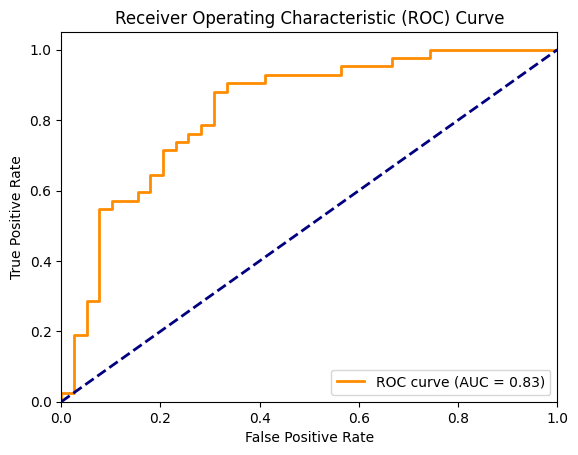

In [41]:
# Hacer predicciones en el conjunto de prueba
y_test_pred = ensemble.predict(X_test_scaled)
y_test_pred_proba = ensemble.predict_proba(X_test_scaled)[:, 1]

# Calcular métricas para el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"AUC-ROC: {test_auc:.3f}")

print("\nComparación de resultados:")
print(f"Accuracy - Entrenamiento: {train_accuracy:.3f}, Validación: {val_accuracy:.3f}, Prueba: {test_accuracy:.3f}")
print(f"AUC-ROC - Entrenamiento: {train_auc:.3f}, Validación: {val_auc:.3f}, Prueba: {test_auc:.3f}")

# Calcular error relativo entre validación y prueba
accuracy_error_test = abs(val_accuracy - test_accuracy) / val_accuracy * 100
auc_error_test = abs(val_auc - test_auc) / val_auc * 100

print(f"\nError relativo entre validación y prueba:")
print(f"Accuracy: {accuracy_error_test:.2f}%")
print(f"AUC-ROC: {auc_error_test:.2f}%")

if max(accuracy_error_test, auc_error_test) < 5:
    print("\nEl modelo mantiene un buen rendimiento en el conjunto de prueba.")
else:
    print("\nHay una diferencia significativa entre validación y prueba. Puede ser necesario revisar el modelo.")

# Informe de clasificación detallado
print("\nInforme de clasificación detallado:")
print(classification_report(y_test, y_test_pred))

# Visualizar la curva ROC
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()